# Implementation of a KAN for regression
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of regression and compare it against a neural network of a similar architecture.

## Initialisations

In [3]:
!pip install pykan

In [4]:
import torch
import pandas as pd
from kan import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


## Loading the Dataset

In [6]:
csv_file_path = 'data.csv'
df = pd.read_csv(csv_file_path)

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
columns_to_label_encode = ['NOMBRE_UNIDAD_EDUC', 'NOMBRE_COMUNA_EGRESO',
                            'PAGO_MATRICULA2020', 'PAGO_MENSUAL2020', 'PAGO_MATRICULA2021', 'PAGO_MENSUAL2021',
                            'PAGO_MATRICULA2022', 'PAGO_MENSUAL2022', 'PAGO_MATRICULA2023', 'PAGO_MENSUAL2023']

label_encoder = LabelEncoder()
for column in columns_to_label_encode:
    df.loc[:, column] = label_encoder.fit_transform(df.loc[:, column])

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [9]:
data = df_normalized.drop(['MRUN', 'CLEC_REG_ACTUAL', 'MATE1_REG_ACTUAL', 'MATE2_REG_ACTUAL', 'PROMEDIO_CM_MAX', ], axis=1).values
target = df_normalized['PROMEDIO_CM_MAX'].values

In [10]:
# Convert to PyTorch tensors
data_tensor = torch.tensor(data, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

# Split dataset into train and test sets
train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

# Create data loaders (optional, if you want to batch and shuffle the data)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

train_inputs = torch.empty(0, 33, device=device)
train_labels = torch.empty(0, dtype=torch.long, device=device)
test_inputs = torch.empty(0, 33, device=device)
test_labels = torch.empty(0, dtype=torch.long, device=device)

# Concatenate all data into a single tensor on the specified device
for data, labels in tqdm(train_loader):
    train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
    train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

for data, labels in tqdm(test_loader):
    test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
    test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

dataset = {}
dataset['train_input'] = train_inputs
dataset['test_input'] = test_inputs
dataset['train_label'] = train_labels.reshape(-1, 1)
dataset['test_label'] = test_labels.reshape(-1, 1)


100%|██████████| 28413/28413 [00:04<00:00, 5702.25it/s]


In [41]:
dataset

{'train_input': tensor([[0.0000, 0.2203, 0.5042,  ..., 0.8333, 0.8333, 0.0000],
         [0.0000, 0.1263, 0.5019,  ..., 0.6667, 0.6667, 0.0000],
         [0.3333, 0.0037, 0.6448,  ..., 0.8333, 0.8333, 0.0000],
         ...,
         [0.3333, 0.0991, 0.3564,  ..., 0.6667, 0.6667, 0.0000],
         [0.3333, 0.0463, 0.2150,  ..., 0.0000, 0.5000, 0.0000],
         [0.3333, 0.0811, 0.9915,  ..., 0.6667, 0.6667, 0.0000]],
        device='cuda:0'),
 'test_input': tensor([[0.3333, 0.0888, 0.2121,  ..., 0.8333, 0.8333, 0.0000],
         [0.0000, 0.1330, 0.5235,  ..., 0.6667, 0.8333, 0.0000],
         [0.3333, 0.1786, 0.3263,  ..., 0.6667, 0.8333, 0.0000],
         ...,
         [0.0000, 0.0044, 0.6372,  ..., 0.0000, 0.5000, 0.0000],
         [0.3333, 0.2648, 0.3003,  ..., 0.8333, 0.8333, 0.0000],
         [0.0000, 0.1820, 0.4248,  ..., 0.6667, 0.6667, 0.0000]],
        device='cuda:0'),
 'train_label': tensor([[0.6343],
         [0.3595],
         [0.5883],
         ...,
         [0.5075],
    

In [11]:
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([113651, 33])
Train target shape: torch.Size([113651, 1])
Test data shape: torch.Size([28413, 33])
Test target shape: torch.Size([28413, 1])


## Creating and Training the KAN

In [12]:
image_folder = 'video_img'

model = KAN(width=[33, 5, 1], grid=10, k=3, seed=0, device=device)

In [13]:
def train_mse():
    with torch.no_grad():
        predictions = model(dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, dataset['test_label'])
    return mse

results = model.train(dataset, opt="LBFGS", device=device, metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=5, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)

train loss: 1.29e-01 | test loss: 1.29e-01 | reg: 1.25e+01 : 100%|████| 5/5 [05:13<00:00, 62.65s/it]


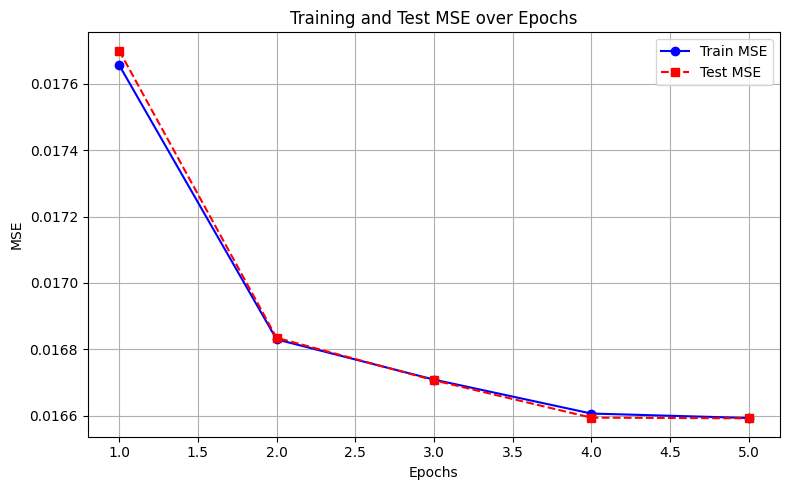

In [14]:
import matplotlib.pyplot as plt

train_mse = results['train_mse']
test_mse = results['test_mse']
epochs = range(1, len(train_mse) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_mse, marker='o', linestyle='-', color='b', label='Train MSE')
plt.plot(epochs, test_mse, marker='s', linestyle='--', color='r', label='Test MSE')

plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Test MSE over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
print(results['train_mse'][-1], results['test_mse'][-1])

0.016593344509601593 0.016592297703027725


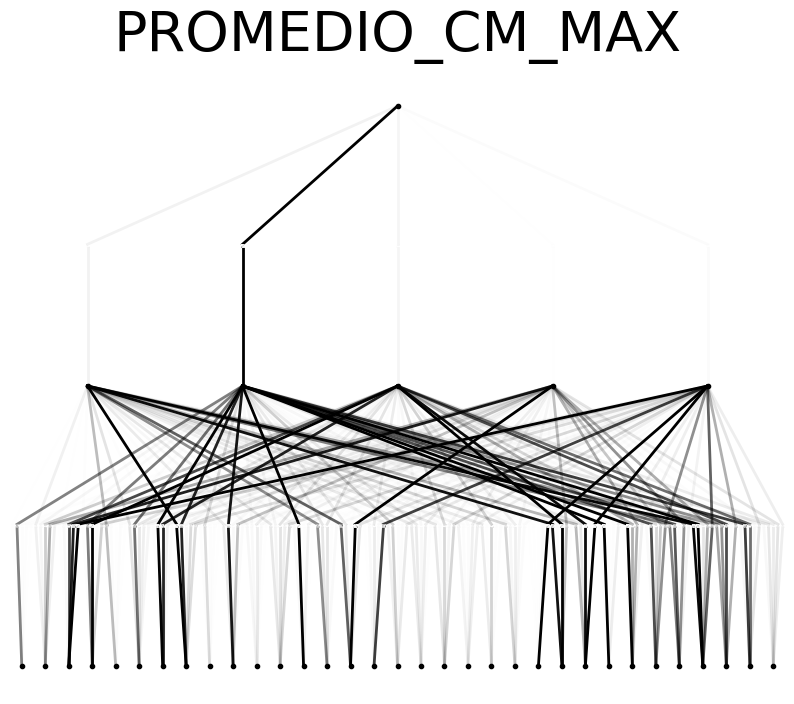

In [16]:
model.plot(beta=50, scale=1, out_vars=['PROMEDIO_CM_MAX'])

In [17]:
import moviepy.video.io.ImageSequenceClip

video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4
